<a href="https://colab.research.google.com/github/babaroscopy/colab/blob/main/Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rohit-Kundu/Ensemble-Pneumonia-Detection.git

Cloning into 'Ensemble-Pneumonia-Detection'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 85 (delta 50), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [2]:
!pip install -r Ensemble-Pneumonia-Detection/requirements.txt

ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu102 (from versions: 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1)
ERROR: No matching distribution found for torch==1.9.0+cu102


In [3]:
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [6]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [7]:
ls

chest-xray-pneumonia.zip  flickr8k.zip  kaggle.json


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [10]:
# Location of Zip File
drive_path = '/content/gdrive/My Drive/Kaggle/chest-xray-pneumonia.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'chest-xray-pneumonia.zip'

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
!cp -r chest_xray/chest_xray/ Ensemble-Pneumonia-Detection/data/

In [12]:
!cp -r Ensemble-Pneumonia-Detection/data/test/NORMAL/*.jpeg Ensemble-Pneumonia-Detection/data/val/NORMAL/
!cp -r Ensemble-Pneumonia-Detection/data/test/PNEUMONIA/*.jpeg Ensemble-Pneumonia-Detection/data/val/PNEUMONIA/

In [13]:
!mkdir Ensemble-Pneumonia-Detection/train_csv
!mkdir Ensemble-Pneumonia-Detection/test_csv
#f = open("Ensemble-Pneumonia-Detection/train_csv/resnet18_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/resnet18_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/googlenet_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/googlenet_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/densenet121_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/densenet121_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/vgg_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/vgg_test.csv", "x")
f = open("Ensemble-Pneumonia-Detection/train_csv/inception_train.csv", "x")
f = open("Ensemble-Pneumonia-Detection/test_csv/inception_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/alexnet_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/alexnet_test.csv", "x")
f = open("Ensemble-Pneumonia-Detection/train_labels.csv", "x")
f = open("Ensemble-Pneumonia-Detection/test_labels.csv", "x")

In [57]:
pip install scikit-plot

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import *
import math
import scikitplot as skplt 

In [36]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = "Ensemble-Pneumonia-Detection/data"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['NORMAL', 'PNEUMONIA']


In [17]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

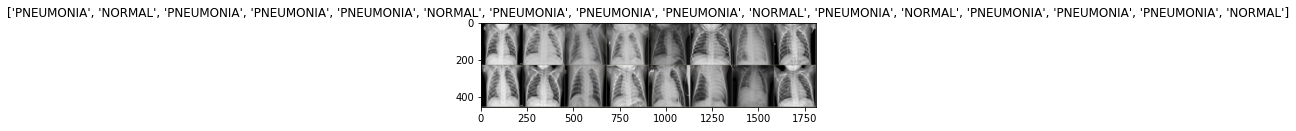

In [18]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
def plot(val_loss,train_loss,typ):
    plt.title("Inception v3:")
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [20]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_loss_gph.append(epoch_loss)
              train_acc_gph.append(epoch_acc)
            if phase == 'val':
              val_loss_gph.append(epoch_loss)
              val_acc_gph.append(epoch_acc)
            
           # plot(val_loss_gph,train_loss_gph, "Loss")
           # plot(val_acc_gph,train_acc_gph, "Accuracy")

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, data_dir+"/"+model_name+".h5")
                print('==>Model Saved')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot(val_loss_gph,train_loss_gph, "Loss")
    plot(val_acc_gph,train_acc_gph, "Accuracy")
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Inception v3**

In [29]:
model = models.inception_v3(pretrained = True)

#num_ftrs = model.fc.in_features  ##for googlenet, resnet18
#num_ftrs = model.classifier[6].in_features  ## for densenet169
# Handle the auxilary net
#num_ftrs = model.AuxLogits.fc.in_features
#model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
model.aux_logits=False
num_ftrs = model.fc.in_features
print("Number of features: "+str(num_ftrs))

Number of features: 2048


In [30]:
#model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
#model.classifier[6] = nn.Linear(num_ftrs, num_classes) ## for densenet169
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)
model = model.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [32]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

Epoch 1/30
----------
train Loss: 0.1179 Acc: 0.9569
val Loss: 0.4120 Acc: 0.8750
==>Model Saved

Epoch 2/30
----------
train Loss: 0.0375 Acc: 0.9889
val Loss: 0.5961 Acc: 0.8203

Epoch 3/30
----------
train Loss: 0.0323 Acc: 0.9887
val Loss: 1.0996 Acc: 0.7906

Epoch 4/30
----------
train Loss: 0.0106 Acc: 0.9971
val Loss: 1.1074 Acc: 0.7781

Epoch 5/30
----------
train Loss: 0.0201 Acc: 0.9941
val Loss: 0.7601 Acc: 0.8703

Epoch 6/30
----------
train Loss: 0.0124 Acc: 0.9973
val Loss: 0.8576 Acc: 0.8391

Epoch 7/30
----------
train Loss: 0.0163 Acc: 0.9948
val Loss: 2.0132 Acc: 0.7594

Epoch 8/30
----------
train Loss: 0.0228 Acc: 0.9918
val Loss: 1.8321 Acc: 0.7500

Epoch 9/30
----------
train Loss: 0.0044 Acc: 0.9987
val Loss: 1.4119 Acc: 0.7891

Epoch 10/30
----------
train Loss: 0.0089 Acc: 0.9967
val Loss: 1.6295 Acc: 0.8188

Epoch 11/30
----------
train Loss: 0.0022 Acc: 0.9996
val Loss: 1.4244 Acc: 0.8375

Epoch 12/30
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 1.7555

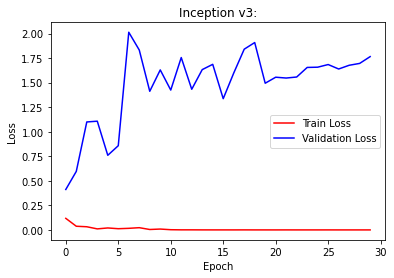

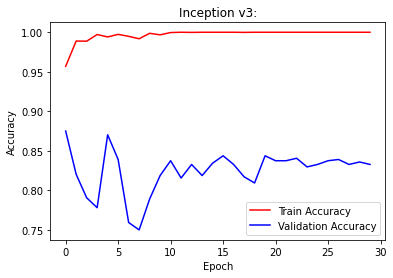

In [37]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=30, model_name = "inception_v3")

In [38]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['val'],batch_size=1)


Getting the Probability Distribution


In [39]:
model=model.eval()

In [40]:
correct = 0
total = 0
data_dir = "Ensemble-Pneumonia-Detection/train_csv"
#Train Probabilities
f = open(data_dir+"/inception_train.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(trainloader),num_classes))
      for i,data in enumerate(trainloader):
          images, labels = data
          sample_fname, _ = trainloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Train Accuracy = ",100*correct/total)
for i in range(len(trainloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)

f.close()

Train Accuracy =  99.32898773006134


In [41]:
data_dir = "Ensemble-Pneumonia-Detection"

f = open(data_dir+"/train_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

In [42]:
data_dir = "Ensemble-Pneumonia-Detection/test_csv"

#Test Probabilities
f = open(data_dir+"/inception_test.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for i,data in enumerate(testloader):
          images, labels = data
          sample_fname, _ = testloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Test Accuracy = ",100*correct/total)
for i in range(len(testloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)

f.close()

Test Accuracy =  98.03620218579235


In [43]:
data_dir = "Ensemble-Pneumonia-Detection"

f = open(data_dir+"/test_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

**ensemble**

In [44]:
def getfile(filename):
    root="./"
    file = root+filename
    if '.csv' not in file:
        file+='.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)[:,:-1] #Since last column has image names
    return df

In [45]:
def getlabels(filename):
    root="./"
    file = root+filename
    if '.csv' not in file:
        file+='.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)[:,1] #Since first column has image names
    return df.astype(int)

In [46]:
def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

In [59]:
def metrics(labels,predictions,classes):
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names = classes,digits = 4))
    skplt.metrics.plot_confusion_matrix(labels, predictions, normalize=True)
    matrix = confusion_matrix(labels, predictions,normalize='all')
    '''
    print("Confusion matrix:")
    print(matrix)'''
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))

In [48]:

def get_scores(labels, *argv):
    #outputs matrix of shape (no. of arg, 4) of precision, recall, f1-score, Area Under Curve
    count = len(argv)
    metrics = np.zeros(shape=(4,count))
    num_classes = np.unique(labels).shape[0]
    for i, arg in enumerate(argv):
        preds = predicting(arg)
        if num_classes==2:
            pre = precision_score(labels,preds[:640])
            rec = recall_score(labels,preds[:640])
            f1 = f1_score(labels,preds[:640])
            auc = roc_auc_score(labels,preds[:640])
        else:
            pre = precision_score(labels,preds[:640],average='macro')
            rec = recall_score(labels,preds[:640],average='macro')
            f1 = f1_score(labels,preds[:640],average='macro')
            auc = roc_auc_score(labels,arg[:640],average='macro',multi_class='ovo')
        metrics[:,i] = np.array([pre,rec,f1,auc])
    weights = get_weights(np.transpose(metrics))
    #print("Weights: ",weights)
    return weights
    '''

def get_scores(labels,*argv):
    #outputs matrix of shape (no. of arg, 4) of precision, recall, f1-score, Area Under Curve
    count = len(argv)
    metrics = np.zeros(shape=(4,count))
    num_classes = np.unique(labels).shape[0]
    for i,arg in enumerate(argv):
        preds = predicting(arg)
        print(labels.shape)
        print(preds.shape)
        print(len(labels))
        print(len(preds))
        if num_classes==2:
            pre = precision_score(labels,preds)
            rec = recall_score(labels,preds)
            f1 = f1_score(labels,preds)
            auc = roc_auc_score(labels,preds)
        else:
            pre = precision_score(labels,preds,average='macro')
            rec = recall_score(labels,preds,average='macro')
            f1 = f1_score(labels,preds,average='macro')
            auc = roc_auc_score(labels,arg,average='macro',multi_class='ovo')
        metrics[:,i] = np.array([pre,rec,f1,auc])
    weights = get_weights(np.transpose(metrics))
    #print("Weights: ",weights)
    return weights
'''

In [49]:
def get_weights(matrix):
    weights = []
    for i in range(matrix.shape[0]):
        m = matrix[i]
        w = 0
        for j in range(m.shape[0]):
            w+=np.tanh(m[j])
        weights.append(w)
    return weights

In [50]:
root_train = "Ensemble-Pneumonia-Detection/train_csv/"
root_test  = "Ensemble-Pneumonia-Detection/test_csv/"
'''
train_labels = "Ensemble-Pneumonia-Detection/train_labels.csv"
train_labels = getlabels(train_labels)

test_labels = "Ensemble-Pneumonia-Detection/test_labels.csv"
test_labels = getlabels(test_labels)
'''

'\ntrain_labels = "Ensemble-Pneumonia-Detection/train_labels.csv"\ntrain_labels = getlabels(train_labels)\n\ntest_labels = "Ensemble-Pneumonia-Detection/test_labels.csv"\ntest_labels = getlabels(test_labels)\n'

In [51]:
csv_list = os.listdir(root_train)
p1_train = getfile(root_train+csv_list[0])
#p2_train = getfile(root_train+csv_list[1])
#p3_train = getfile(root_train+csv_list[2])

train_labels = "Ensemble-Pneumonia-Detection/train_labels.csv"
train_labels = getlabels(train_labels)
#train_labels = getlabels(train_labels)

p1_test = getfile(root_test+csv_list[0].replace('train','test'))
#p2_test = getfile(root_test+csv_list[1].replace('train','test'))
#p3_test = getfile(root_test+csv_list[2].replace('train','test'))

test_labels = "Ensemble-Pneumonia-Detection/test_labels.csv"
test_labels = getlabels(test_labels)
#test_labels = getlabels(test_labels)

In [52]:
weights = get_scores(train_labels, p1_train)

ensemble_prob = weights[0]*p1_test
preds = predicting(ensemble_prob)
correct = np.where(preds == test_labels)[0].shape[0]
total = test_labels.shape[0]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
from sklearn import metrics
import matplotlib.pyplot as plt

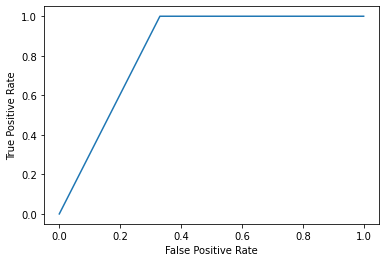

In [54]:
fpr, tpr, _ = metrics.roc_curve(test_labels,preds)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

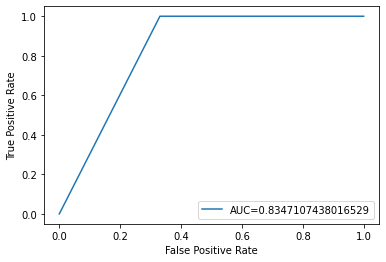

In [55]:
auc = metrics.roc_auc_score(test_labels,preds)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy =  0.875
Classification Report:
              precision    recall  f1-score   support

      Normal     1.0000    0.6694    0.8020       242
   Pneumonia     0.8326    1.0000    0.9087       398

    accuracy                         0.8750       640
   macro avg     0.9163    0.8347    0.8553       640
weighted avg     0.8959    0.8750    0.8683       640


Classwise Accuracy :[0.66942149 1.        ]


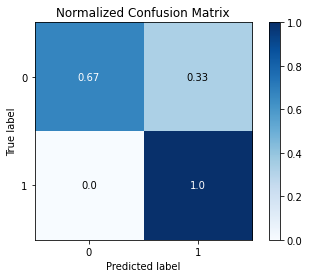

In [60]:
print("Accuracy = ",correct/total)
classes = ['Normal','Pneumonia']
metrics(test_labels,preds,classes)